In [1]:
import os  
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib

import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Simhei']
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题,或者转换负号为字符串
# 设置VSCode中显示图表
matplotlib.use('module://matplotlib_inline.backend_inline')
plt.style.use('seaborn-v0_8')

# 本地文件路径配置
DATA_PATH = Path(r"C:\Users\86158\Desktop\佳哥的文件夹\大三下学期作业\python数据分析\csv文件")
PLAYER_FILES = {
    'Wembanyama': DATA_PATH / "wembavi01_2025_sample.csv",
    'Anthony Davis': DATA_PATH / "davis_sample.csv",  # 请自行准备示例文件
    'Jaren Jackson': DATA_PATH / "jackson_sample.csv"  # 请自行准备示例文件
}

def load_local_data(player_name: str) -> pd.DataFrame:
    """从本地CSV加载球员数据"""
    filepath = PLAYER_FILES.get(player_name)
    if not filepath or not filepath.exists():
        raise FileNotFoundError(f"{player_name}的数据文件不存在: {filepath}")
    
    df = pd.read_csv(filepath)
    
    # 确保必要的列存在
    required_cols = ['PTS', 'TRB', 'AST', 'FG%', '3P%', 'FT%']
    for col in required_cols:
        if col not in df.columns:
            df[col] = np.nan  # 添加缺失列
    
    return df

In [2]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """数据清洗处理"""
    # 删除无用列
    df = df.drop(columns=['Rk', 'GmSc'], errors='ignore')
    
    # 转换百分比数据
    pct_cols = ['FG%', '3P%', 'FT%']
    for col in pct_cols:
        if col in df.columns:
            # 处理可能已转换为float的数据
            if df[col].dtype == object:
                df[col] = df[col].str.rstrip('%').astype(float) / 100
            else:
                df[col] = pd.to_numeric(df[col], errors='coerce') / 100
    
    # 转换数值型数据
    num_cols = ['PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']
    for col in num_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 特殊处理比赛时间(MP)
    if 'MP' in df.columns:
        df['MP'] = df['MP'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
        # 如果MP是"MM:SS"格式
        if df['MP'].dtype == object:
            df['MP'] = df['MP'].apply(
                lambda x: float(x.split(':')[0]) + float(x.split(':')[1])/60 
                if isinstance(x, str) and ':' in x else np.nan
            )
    
    return df

In [3]:
def handle_missing(df: pd.DataFrame) -> pd.DataFrame:
    """处理缺失值"""
    # 删除关键指标全部缺失的行
    df = df.dropna(subset=['PTS', 'TRB', 'AST'], how='all')
    
    # 填充命中率缺失值
    pct_cols = ['FG%', '3P%', 'FT%']
    for col in pct_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    
    # 填充其他数值列
    num_cols = ['STL', 'BLK', 'TOV', 'PF']
    for col in num_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    
    return df

In [4]:
def handle_outliers(df):
    """
    异常值综合处理方案：
    1. Z-score检测极端值（|Z|>3）
    2. 缩尾法处理（5%-95%分位数）
    3. 特定逻辑处理（如上场时间>48分钟视为异常）
    """
    # 1. Z-score检测
    z_threshold = 3
    for col in ['PTS', 'TRB', 'BLK']:
        if col in df.columns:
            z_scores = np.abs(stats.zscore(df[col]))
            outliers = z_scores > z_threshold
            print(f"检测到{col}异常值{sum(outliers)}个")
    
    # 2. 缩尾法处理关键指标
    for col in ['PTS', 'TRB', 'AST', 'BLK']:
        if col in df.columns:
            lower = df[col].quantile(0.05)
            upper = df[col].quantile(0.95)
            df[col] = df[col].clip(lower, upper)
    
    # 3. 比赛时间逻辑校验
    if 'MP' in df.columns:
        df['MP'] = df['MP'].apply(lambda x: min(x, 48))
    
    return df

以上为数据预处理部分代码

In [5]:
def fetch_player_gamelog_bref(player_id: str, season: int, retries=3) -> pd.DataFrame:
    url = f"https://www.basketball-reference.com/players/{player_id[0]}/{player_id}/gamelog/{season}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
        "Accept-Language": "en-US,en;q=0.9"
    }
    
    proxies = {
        'http': 'http://proxy.example.com:8080',  # 替换为实际可用代理
        'https': 'http://proxy.example.com:8080'
    }
    
    for attempt in range(retries):
        try:
            res = requests.get(url, headers=headers, proxies=proxies, timeout=10)
            res.raise_for_status()
            
            # 添加响应内容检查
            if "Page Not Found" in res.text:
                raise ValueError(f"Player {player_id} not found for season {season}")
                
            tables = pd.read_html(res.text)
            if not tables:
                raise ValueError("No tables found in HTML")
                
            for table in tables:
                if 'PTS' in table.columns:
                    df = table.copy()
                    # 添加数据有效性检查
                    if len(df) < 5:
                        raise ValueError("Table too small, likely incorrect")
                    return process_raw_table(df)
                    
            raise ValueError("No table with PTS column found")
            
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {str(e)}")
            if attempt == retries - 1:
                raise
            time.sleep(2)  # 等待2秒后重试

def process_raw_table(df):
    """处理原始表格的通用清洗逻辑"""
    df = df[df['G'].notna()]
    df = df[df['Date'] != 'Date']
    # 处理表头重复行
    if 'Rk' in df.columns and pd.api.types.is_string_dtype(df['Rk']):
        df = df[df['Rk'] != 'Rk']
    return df.reset_index(drop=True)

In [6]:
def plot_pts_trend(df: pd.DataFrame, player_name: str):
    """得分趋势可视化"""
    plt.figure(figsize=(12, 6))
    
    df = df.copy()
    df['GameIndex'] = range(1, len(df) + 1)
    
    # 计算移动平均
    df['PTS_MA5'] = df['PTS'].rolling(5).mean()
    
    # 绘制折线图
    plt.plot(df['GameIndex'], df['PTS'], 
             marker='o', linestyle='-', color='#1f77b4', 
             label='单场得分', alpha=0.7)
    
    plt.plot(df['GameIndex'], df['PTS_MA5'], 
             linestyle='--', color='#ff7f0e', 
             linewidth=2, label='5场移动平均')
    
    # 标注最高分
    max_idx = df['PTS'].idxmax()
    plt.annotate(f'最高分: {df.loc[max_idx, "PTS"]}',
                 xy=(df.loc[max_idx, 'GameIndex'], df.loc[max_idx, 'PTS']),
                 xytext=(10, 10), textcoords='offset points',
                 arrowprops=dict(arrowstyle='->'))
    
    plt.title(f'{player_name} 赛季得分趋势 (2024-2025)', fontsize=14)
    plt.xlabel('比赛场次', fontsize=12)
    plt.ylabel('得分', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [7]:
# 命中率分布分析代码
def plot_shooting_distribution(df, player_name):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 投篮命中率分布
    sns.histplot(df['FG%']*100, bins=12, kde=True, ax=axes[0], color='royalblue')
    axes[0].set_title(f'{player_name} - 投篮命中率分布', fontsize=12)
    axes[0].set_xlabel('命中率(%)')
    axes[0].axvline(df['FG%'].mean()*100, color='red', linestyle='--')
    
    # 三分命中率分布
    sns.histplot(df['3P%']*100, bins=10, kde=True, ax=axes[1], color='forestgreen')
    axes[1].set_title(f'{player_name} - 三分命中率分布', fontsize=12)
    axes[1].set_xlabel('命中率(%)')
    axes[1].axvline(df['3P%'].mean()*100, color='red', linestyle='--')
    
    # 罚球命中率分布
    sns.histplot(df['FT%']*100, bins=8, kde=True, ax=axes[2], color='purple')
    axes[2].set_title(f'{player_name} - 罚球命中率分布', fontsize=12)
    axes[2].set_xlabel('命中率(%)')
    axes[2].axvline(df['FT%'].mean()*100, color='red', linestyle='--')
    
    plt.tight_layout()
    plt.savefig(f'{player_name}_命中率分布.png')


In [8]:
def plot_accuracy_histograms(df: pd.DataFrame, player_name: str):
    """命中率分布可视化"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    metrics = ['FG%', '3P%', 'FT%']
    titles = ['投篮命中率', '三分命中率', '罚球命中率']
    colors = ['#2ca02c', '#d62728', '#9467bd']
    
    for ax, metric, title, color in zip(axes, metrics, titles, colors):
        if metric in df.columns:
            sns.histplot(df[metric]*100, bins=10, ax=ax, 
                         color=color, kde=True, alpha=0.7)
            ax.set_title(f'{player_name} - {title}', fontsize=12)
            ax.set_xlabel('命中率(%)')
            ax.set_ylabel('场次')
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [9]:
def plot_pts_boxplot(df: pd.DataFrame, player_name: str):
    """得分分布箱型图"""
    plt.figure(figsize=(8, 5))
    
    sns.boxplot(x=df['PTS'], color='#1f77b4', width=0.4)
    
    # 添加数据点
    sns.stripplot(x=df['PTS'], color='#d62728', alpha=0.5, size=6)
    
    plt.title(f'{player_name} 得分分布箱型图', fontsize=14)
    plt.xlabel('得分', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [10]:
def analyze_player(player_name: str):
    """分析单个球员"""
    try:
        print(f"\n{'='*30} 开始分析 {player_name} {'='*30}")
        
        # 1. 加载数据
        df = load_local_data(player_name)
        print(f"已加载 {len(df)} 场比赛数据")
        
        # 2. 数据清洗
        df = clean_data(df)
        print("已完成数据清洗")
        
        # 3. 处理缺失值
        df = handle_missing(df)
        print("已完成缺失值处理")
        
        # 4. 显示基本信息
        print("\n基本统计信息:")
        print(df[['PTS', 'TRB', 'AST', 'FG%', '3P%', 'FT%']].describe().round(1))
        
        # 5. 可视化分析
        plot_pts_trend(df, player_name)
        plot_accuracy_histograms(df, player_name)
        plot_shooting_distribution(df,player_name)
        plot_pts_boxplot(df, player_name)
    
        
        # 6. 保存处理后的数据
        output_path = DATA_PATH / f"{player_name}_processed.csv"
        df.to_csv(output_path, index=False)
        print(f"\n处理后的数据已保存到: {output_path}")
        
    except Exception as e:
        print(f"处理 {player_name} 数据时出错: {str(e)}")
        import traceback
        traceback.print_exc()

In [11]:
def compare_pts_trend(player_dfs: dict):
    """对比多个球员得分趋势可视化"""
    plt.figure(figsize=(12, 6))
    
    for player_name, df in player_dfs.items():
        df = df.copy()
        df['GameIndex'] = range(1, len(df) + 1)
        
        # 计算移动平均
        df['PTS_MA5'] = df['PTS'].rolling(5).mean()
        
        # 绘制折线图
        plt.plot(df['GameIndex'], df['PTS_MA5'], 
                 linestyle='-', linewidth=2, 
                 label=f'{player_name} 5场移动平均')
    
    plt.title('球员得分趋势对比 (2024-2025)', fontsize=14)
    plt.xlabel('比赛场次', fontsize=12)
    plt.ylabel('得分(5场平均)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [12]:
def compare_shooting_percentage(player_dfs: dict):
    """对比多个球员命中率分布可视化"""
    metrics = ['FG%', '3P%', 'FT%']
    titles = ['投篮命中率', '三分命中率', '罚球命中率']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[i]
        for player_name, df in player_dfs.items():
            if metric in df.columns:
                sns.kdeplot(df[metric]*100, ax=ax, label=player_name)
        
        ax.set_title(f'{title}分布对比', fontsize=12)
        ax.set_xlabel('命中率(%)')
        ax.set_ylabel('密度')
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    plt.show()


============================== 开始分析 Wembanyama ==============================
已加载 22 场比赛数据
已完成数据清洗
已完成缺失值处理

基本统计信息:
        PTS   TRB   AST   FG%   3P%   FT%
count  22.0  22.0  22.0  22.0  22.0  22.0
mean   22.4   9.4   3.8   0.0   0.0   0.0
std     5.7   2.9   1.4   0.0   0.0   0.0
min    13.0   5.0   2.0   0.0   0.0   0.0
25%    17.2   7.2   3.0   0.0   0.0   0.0
50%    22.0   9.0   3.5   0.0   0.0   0.0
75%    26.8  11.0   4.8   0.0   0.0   0.0
max    33.0  15.0   7.0   0.0   0.0   0.0


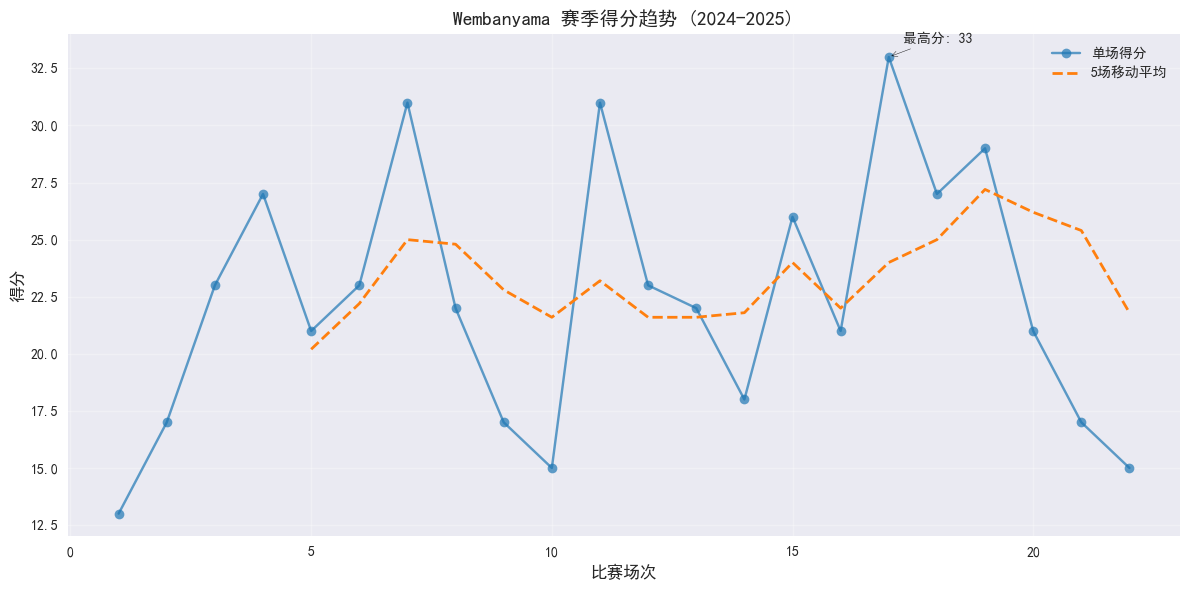

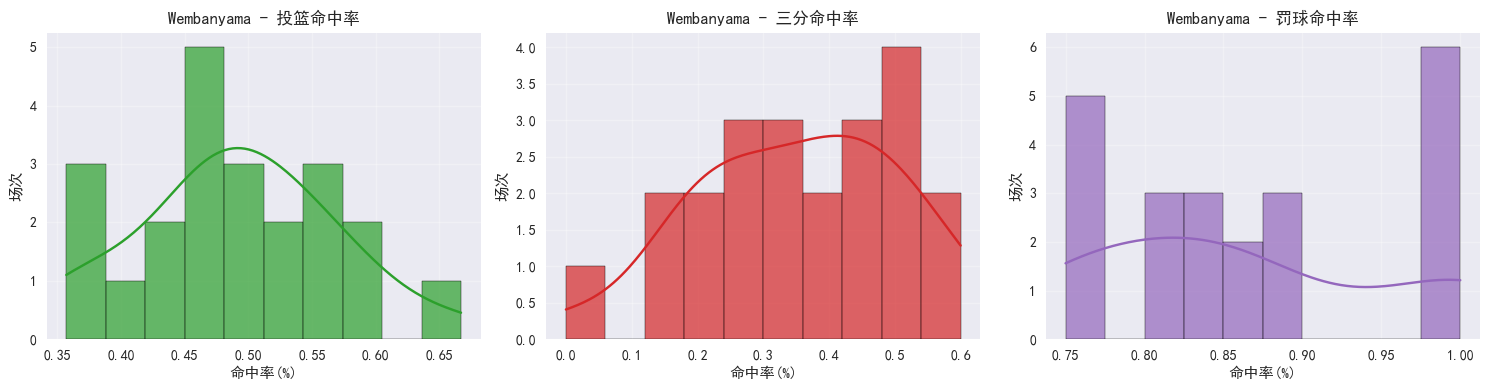

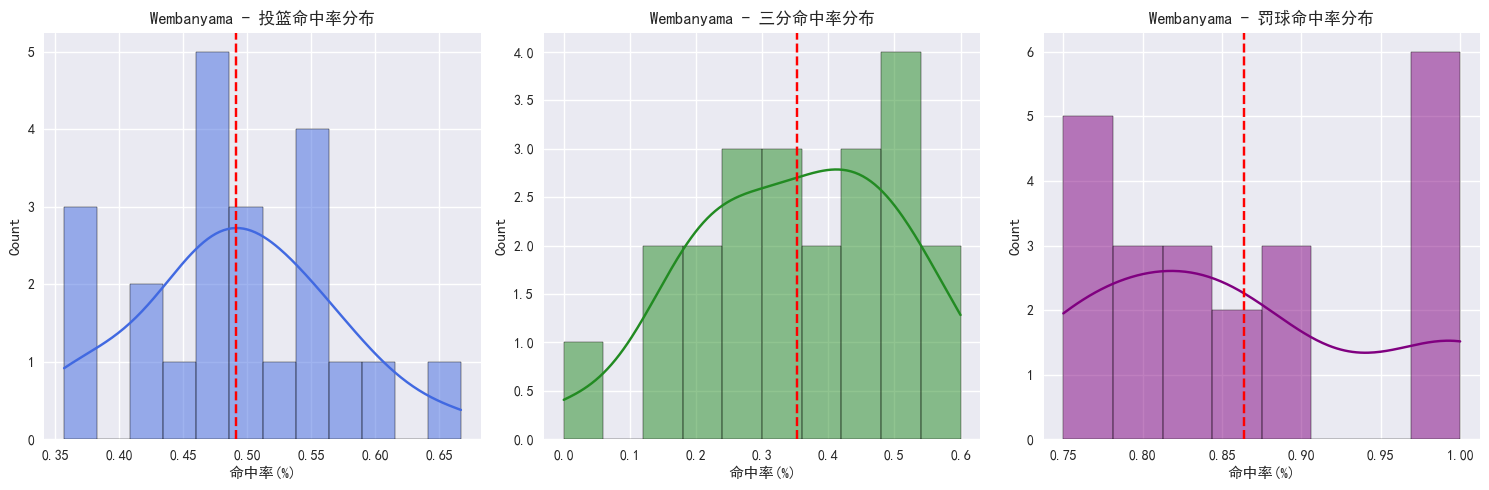

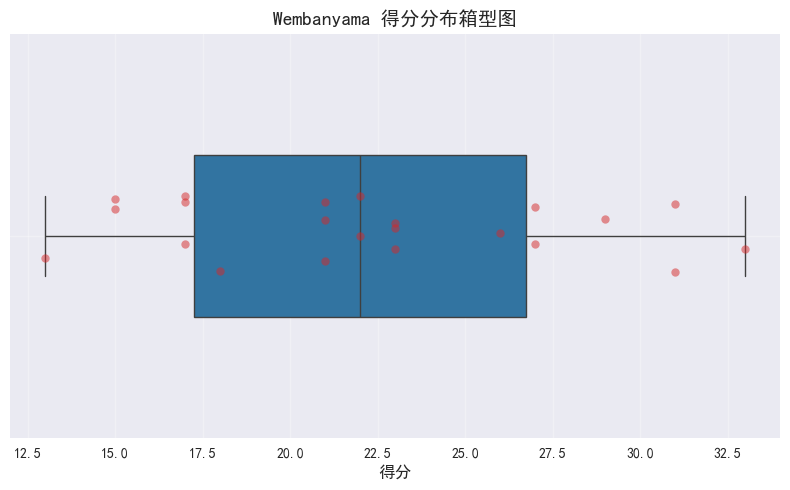


处理后的数据已保存到: C:\Users\86158\Desktop\佳哥的文件夹\大三下学期作业\python数据分析\csv文件\Wembanyama_processed.csv

============================== 开始分析 Anthony Davis ==============================
已加载 24 场比赛数据
已完成数据清洗
已完成缺失值处理

基本统计信息:
        PTS   TRB   AST   FG%   3P%   FT%
count  24.0  24.0  24.0  24.0  24.0  24.0
mean   24.5  12.3   4.4   0.0   0.0   0.0
std     5.0   3.0   1.4   0.0   0.0   0.0
min    16.0   7.0   2.0   0.0   0.0   0.0
25%    20.8  10.8   3.0   0.0   0.0   0.0
50%    25.5  12.0   4.0   0.0   0.0   0.0
75%    27.0  15.0   5.0   0.0   0.0   0.0
max    33.0  18.0   7.0   0.0   0.0   0.0


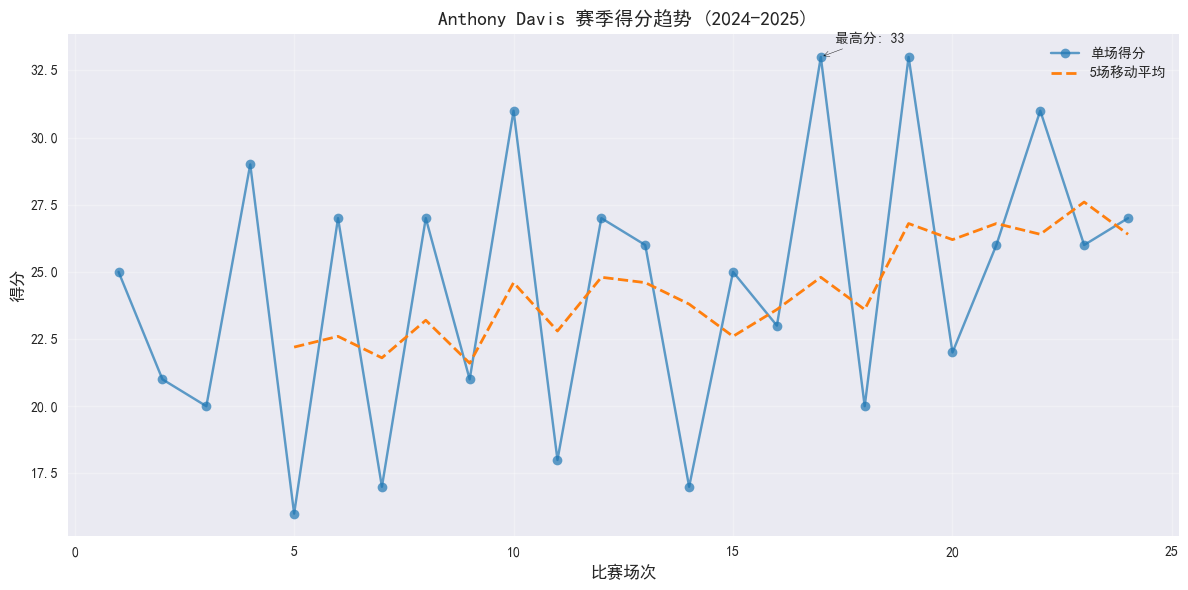

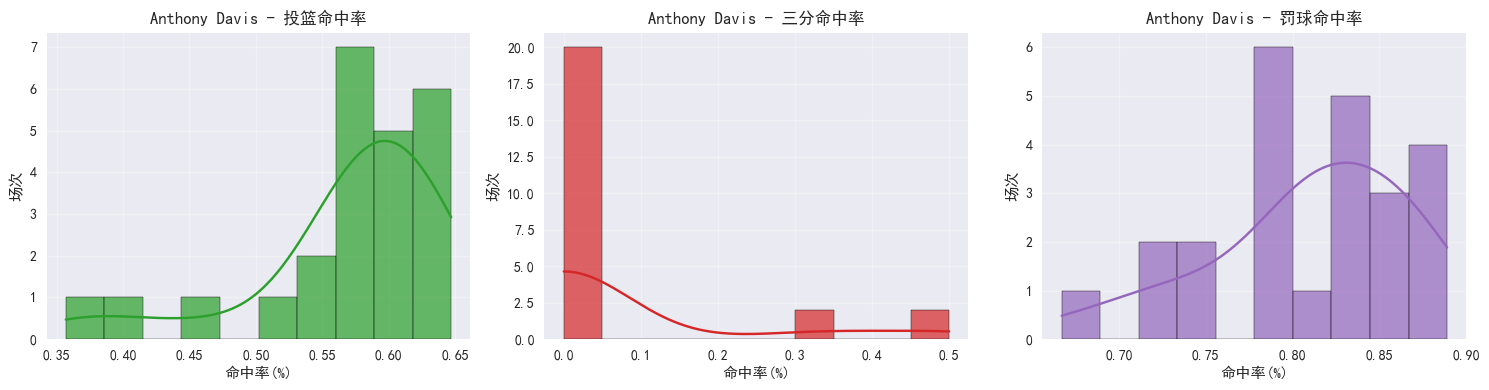

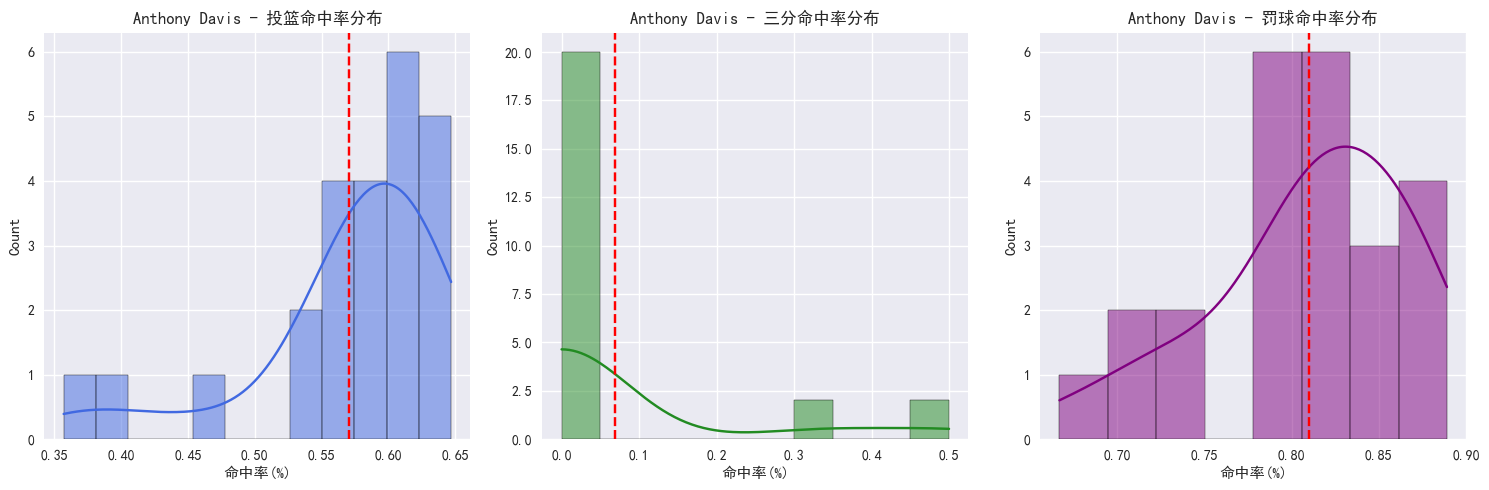

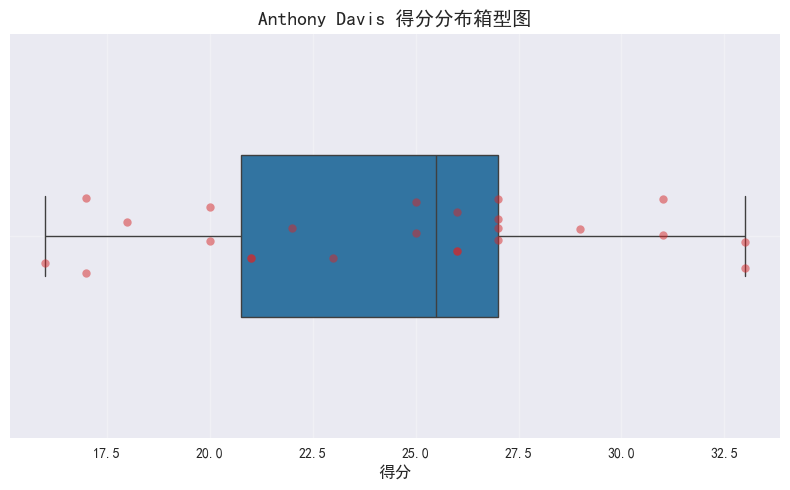


处理后的数据已保存到: C:\Users\86158\Desktop\佳哥的文件夹\大三下学期作业\python数据分析\csv文件\Anthony Davis_processed.csv

============================== 开始分析 Jaren Jackson ==============================
已加载 24 场比赛数据
已完成数据清洗
已完成缺失值处理

基本统计信息:
        PTS   TRB   AST   FG%   3P%   FT%
count  24.0  24.0  24.0  24.0  24.0  24.0
mean   21.5   6.7   3.1   0.0   0.0   0.0
std     5.1   2.0   1.3   0.0   0.0   0.0
min    12.0   3.0   1.0   0.0   0.0   0.0
25%    18.0   5.0   2.0   0.0   0.0   0.0
50%    21.0   7.0   3.0   0.0   0.0   0.0
75%    25.5   8.0   4.0   0.0   0.0   0.0
max    31.0  12.0   6.0   0.0   0.0   0.0


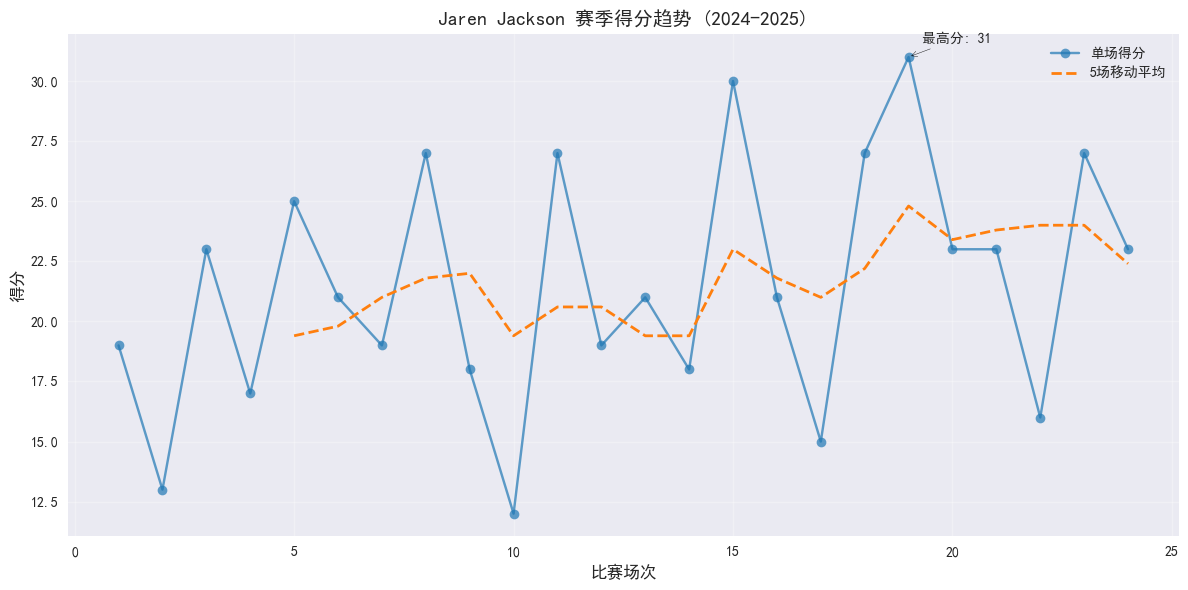

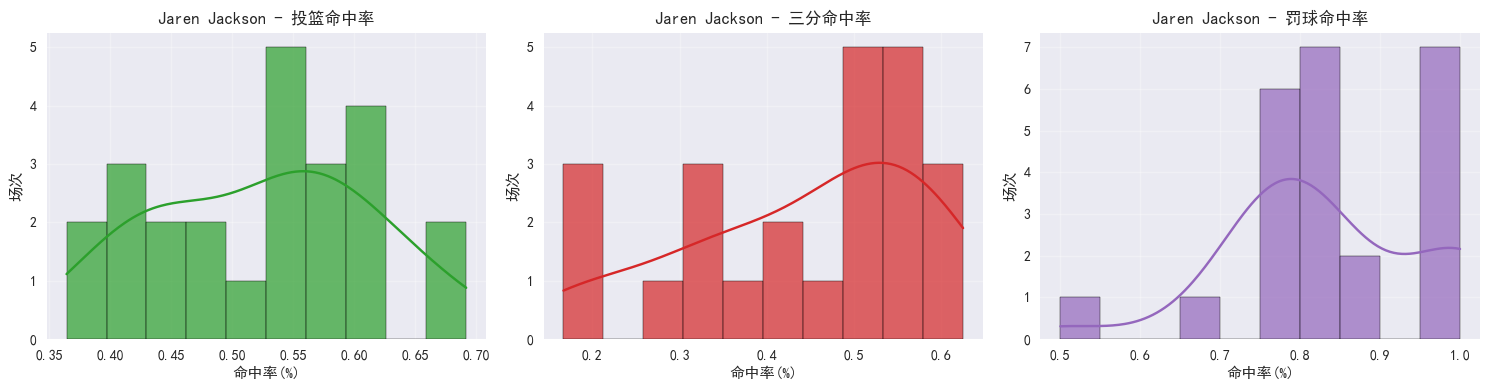

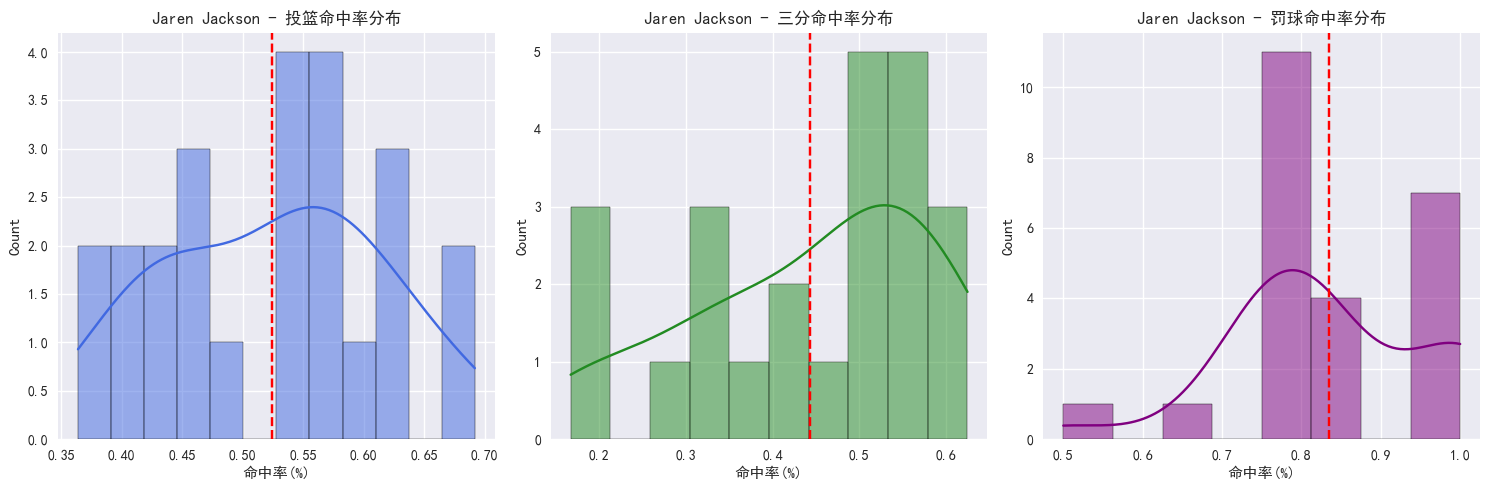

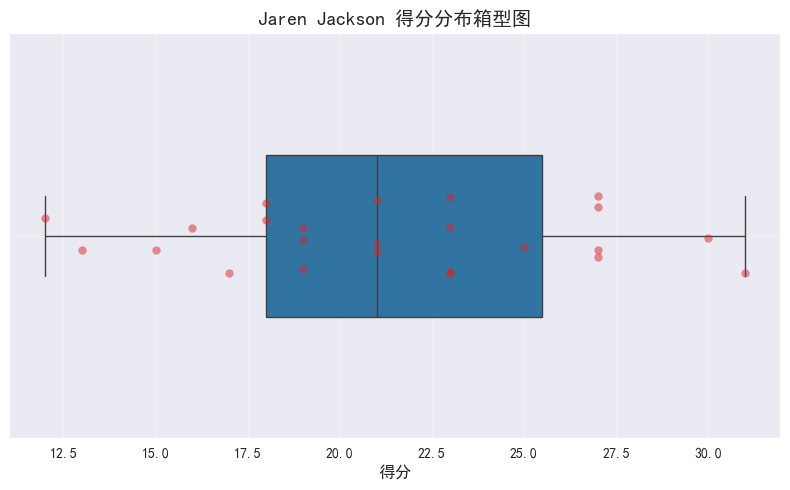


处理后的数据已保存到: C:\Users\86158\Desktop\佳哥的文件夹\大三下学期作业\python数据分析\csv文件\Jaren Jackson_processed.csv


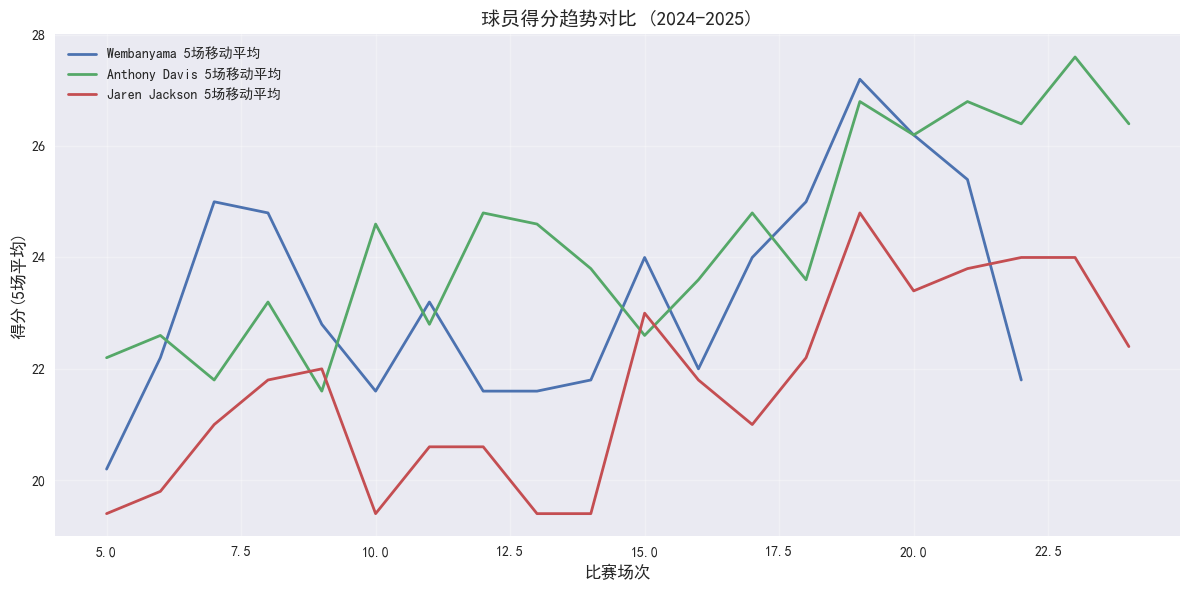

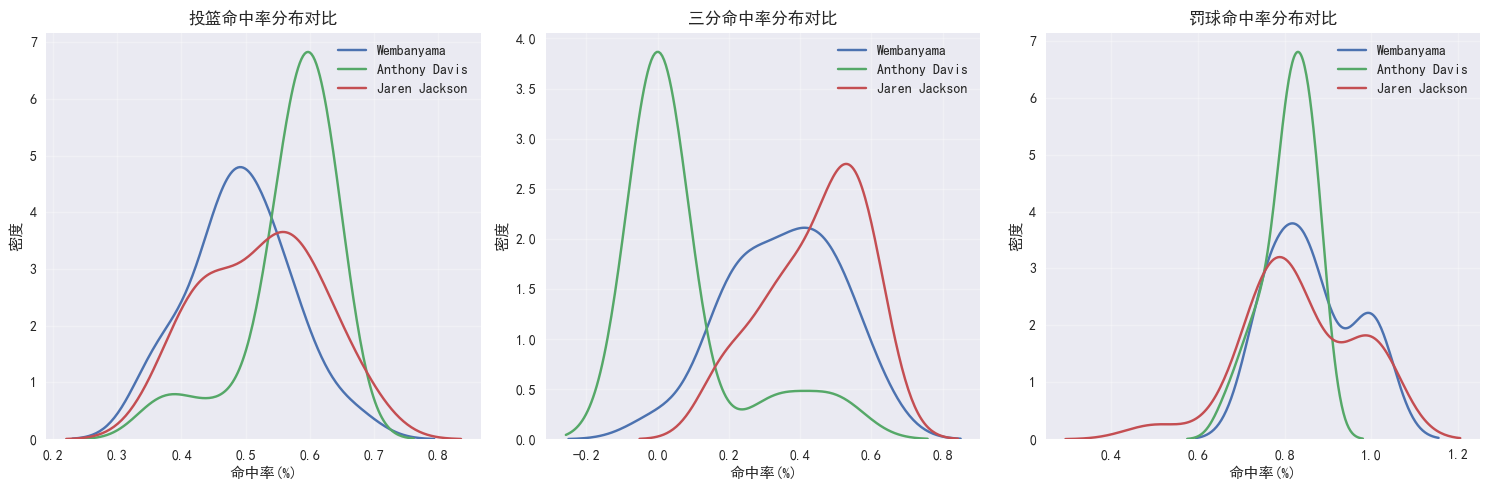


数据分析完成！


In [13]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Simhei']
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题,或者转换负号为字符串
def main():
    """主分析流程"""
    # 确保输出目录存在
    os.makedirs(DATA_PATH, exist_ok=True)
    
    # 分析文班亚马数据
    analyze_player('Wembanyama')
    
    # 分析其他球员数据（以安东尼戴维斯和小贾伦杰克逊为例）
    analyze_player('Anthony Davis')
    analyze_player('Jaren Jackson')
    # 
    player_dfs = {
        'Wembanyama': load_local_data('Wembanyama'),
        'Anthony Davis': load_local_data('Anthony Davis'),
        'Jaren Jackson': load_local_data('Jaren Jackson')
    }

    # 数据清洗和处理
    for name in player_dfs:
        player_dfs[name] = clean_data(player_dfs[name])
        player_dfs[name] = handle_missing(player_dfs[name])

    # 绘制对比图表
    compare_pts_trend(player_dfs)
    compare_shooting_percentage(player_dfs)


    # 

if __name__ == "__main__":
    plt.ion()  # 开启交互模式
    main()
    plt.ioff()  # 关闭交互模式
    print("\n数据分析完成！")